# Clustering YouTube Trending Videos
##### An Unsupervised Learning Approach to Unveil Patterns in Video Popularity

**Notebook Overview:**

1. Problem Description
2. Exploratory Data Analysis (EDA)
3. Model Building and Training
4. Results and Discussion

## **1. Problem Description:**

- **Objective:** Cluster trending YouTube videos based on metadata (e.g., titles, tags, categories) and engagement metrics (e.g., views, likes, comments) to identify patterns contributing to their popularity.
- **Goal:** Understand common characteristics among videos within the same cluster to gain insights into factors influencing video trends.

![YouTube](https://lh3.googleusercontent.com/3zkP2SYe7yYoKKe47bsNe44yTgb4Ukh__rBbwXwgkjNRe4PykGG409ozBxzxkrubV7zHKjfxq6y9ShogWtMBMPyB3jiNps91LoNH8A=s500)

## **2. Exploratory Data Analysis (EDA):**

- **Data loading**

In [52]:
# Load the dataset into a pandas DataFrame.
import pandas as pd
df = pd.read_csv('archive/USvideos.csv')

In [53]:
import json

with open('archive/US_category_id.json') as f:
    categories = json.load(f)
    
category_mapping = {int(item['id']): item['snippet']['title'] for item in categories['items']}

* **Data cleaning**

In [54]:
df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [55]:
# Check for missing values in each column
df.isnull().sum()

video_id                    0
trending_date               0
title                       0
channel_title               0
category_id                 0
publish_time                0
tags                        0
views                       0
likes                       0
dislikes                    0
comment_count               0
thumbnail_link              0
comments_disabled           0
ratings_disabled            0
video_error_or_removed      0
description               570
dtype: int64

In [56]:
# Count number of rows
number_of_rows = len(df)

print(f"Number of entries: {number_of_rows}")

Number of entries: 40949


given we have plenty of data we will drop all 570 entries with no description.

In [58]:
# Remove rows with any missing values
df.dropna(inplace=True)

In [59]:
# Count number of rows
number_of_rows = len(df)
print(f"Number of entries after clean: {number_of_rows}")

Number of entries after clean: 40379


In [60]:
# Remove duplicate rows
df.drop_duplicates(inplace=True)

In [61]:
# Convert 'publish_time' to datetime format
df['publish_time'] = pd.to_datetime(df['publish_time'])

# Convert 'category_id' to integer
df['category_id'] = df['category_id'].astype(int)

In [62]:
# Map category_id to category title
df['category'] = df['category_id'].map(category_mapping)

* **Feature selection**

In [66]:
# Select relevant columns for analysis and create a copy
df_selected = df[['title', 'channel_title', 'category', 'publish_time', 'views', 'likes', 'dislikes', 'comment_count', 'tags']].copy()

# Extract hour, day, and month from 'publish_time'
df_selected['publish_hour'] = df_selected['publish_time'].dt.hour
df_selected['publish_day'] = df_selected['publish_time'].dt.day
df_selected['publish_month'] = df_selected['publish_time'].dt.month

* **Visulization**

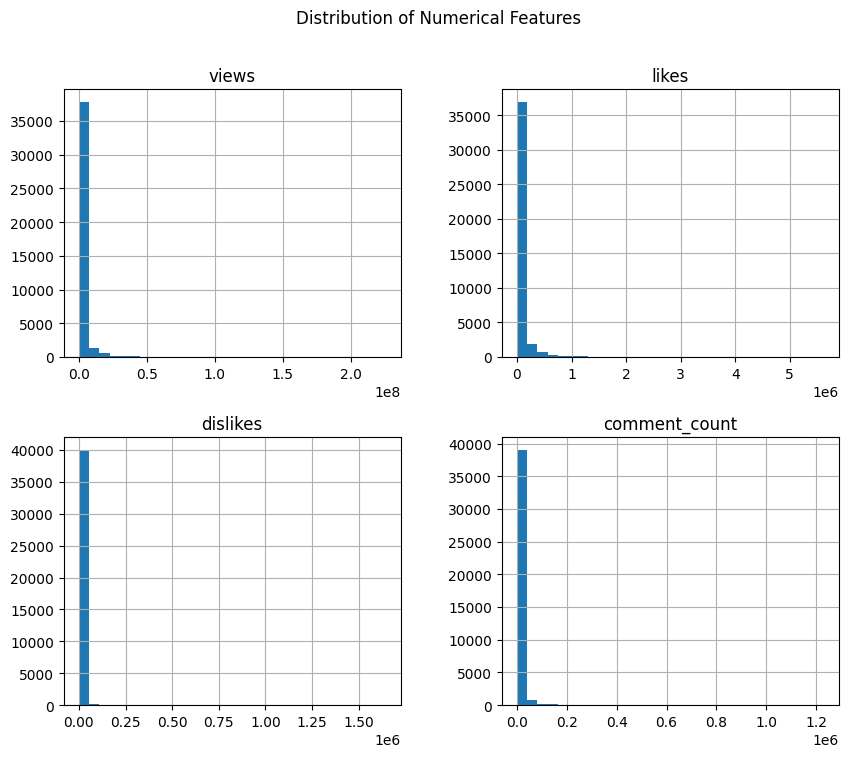

In [73]:
from matplotlib import pyplot as plt

# Plot histograms for numerical features
numerical_features = ['views', 'likes', 'dislikes', 'comment_count']
df_selected[numerical_features].hist(bins=30, figsize=(10, 8))
plt.suptitle('Distribution of Numerical Features')
plt.show()

does not look good so I did some improvement of visulization below

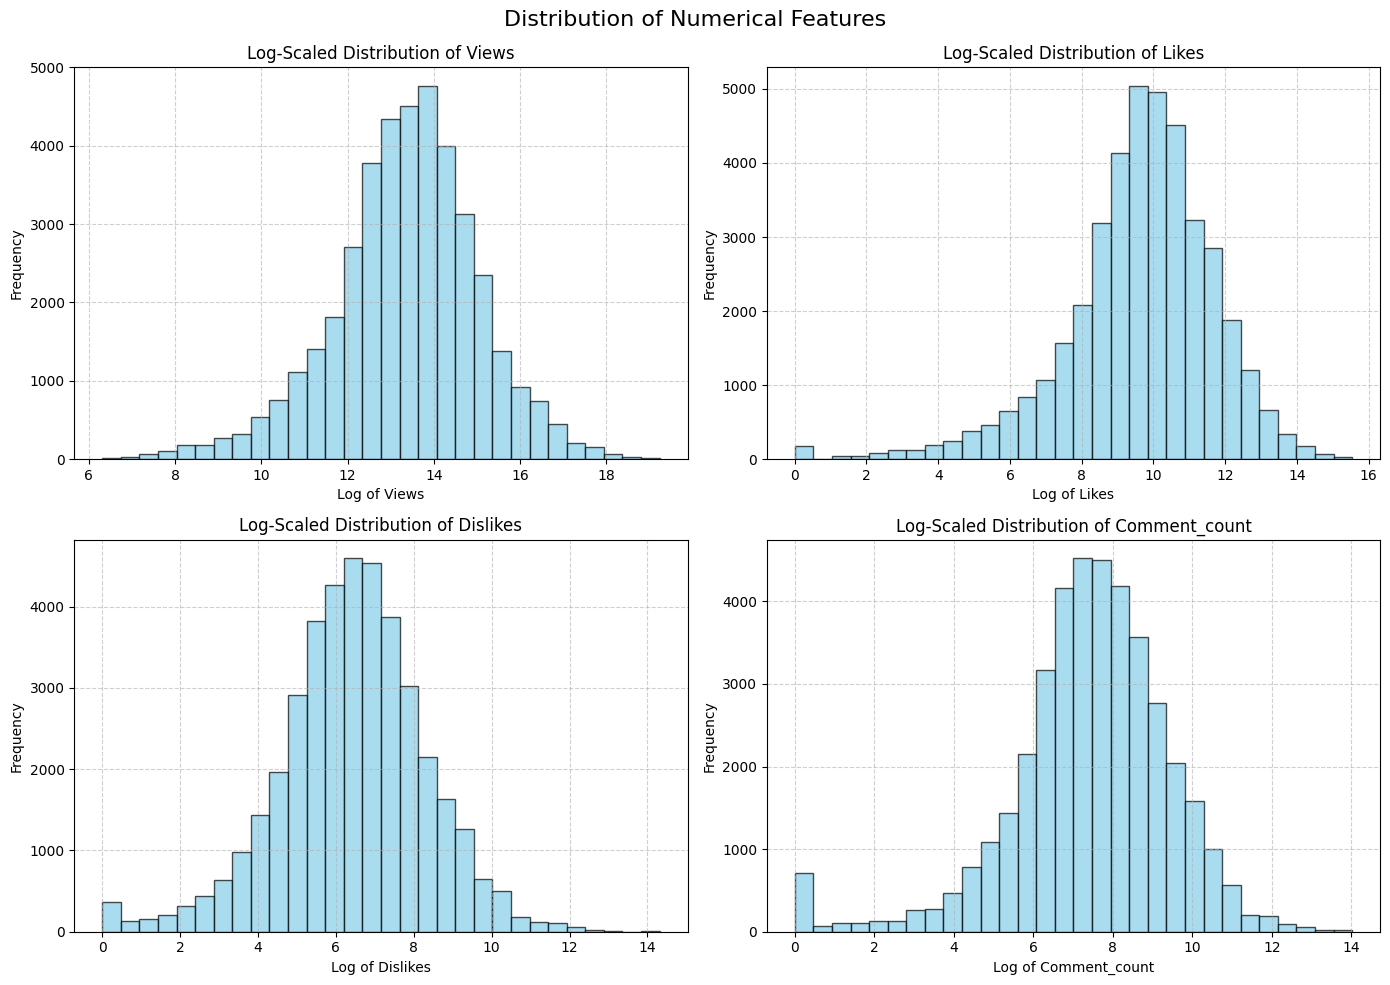

In [72]:
import numpy as np

# Define numerical features
numerical_features = ['views', 'likes', 'dislikes', 'comment_count']

# Set up the figure and axes
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axes = axes.flatten()

# Define a consistent color
color = 'skyblue'

# Plot each feature
for ax, feature in zip(axes, numerical_features):
    # Apply logarithmic scale if data is highly skewed
    if df_selected[feature].skew() > 1:
        data = df_selected[feature].apply(lambda x: np.log1p(x))
        ax.hist(data, bins=30, color=color, edgecolor='black', alpha=0.7)
        ax.set_title(f'Log-Scaled Distribution of {feature.capitalize()}')
        ax.set_xlabel(f'Log of {feature.capitalize()}')
    else:
        ax.hist(df_selected[feature], bins=30, color=color, edgecolor='black', alpha=0.7)
        ax.set_title(f'Distribution of {feature.capitalize()}')
        ax.set_xlabel(f'{feature.capitalize()}')
    ax.set_ylabel('Frequency')
    ax.grid(True, linestyle='--', alpha=0.6)

# Adjust layout and add a main title
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle('Distribution of Numerical Features', fontsize=16)
plt.show()


The histograms for 'views', 'likes', 'dislikes', and 'comment_count' exhibit right-skewed distributions, indicating that while most YouTube videos receive modest engagement, a select few achieve significantly higher interaction levels. This pattern suggests a concentration of popularity among a limited number of videos, highlighting the competitive nature of content engagement on the platform.

1. **Views:**
   - **Distribution Shape:** If the histogram is right-skewed, it indicates that most videos have a lower number of views, with a few achieving exceptionally high view counts.
   - **Central Tendency:** The peak (mode) represents the most common view count range.
   - **Spread:** The width of the distribution shows the variability in view counts among videos.
2. **Likes:**
   - **Distribution Shape:** A right-skewed histogram suggests that while many videos receive a modest number of likes, a select few garner a significantly higher number.
   - **Central Tendency:** The mode indicates the most frequent range of likes.
   - **Spread:** The range of the histogram reveals the diversity in the number of likes across videos.
3. **Dislikes:**
   - **Distribution Shape:** If the histogram is right-skewed, it means that most videos have few dislikes, with only a few receiving a large number.
   - **Central Tendency:** The mode shows the most common range of dislikes.
   - **Spread:** The extent of the distribution indicates the variation in dislikes among videos.
4. **Comment Count:**
   - **Distribution Shape:** A right-skewed histogram suggests that the majority of videos have a lower number of comments, with a few having a high comment count.
   - **Central Tendency:** The mode represents the most frequent range of comment counts.
   - **Spread:** The width of the histogram reflects the variability in comment counts across videos.

**General Observations:**

- **Skewness:** Right-skewed distributions are common in social media metrics, indicating that while most content receives moderate engagement, a small proportion achieves viral status.
- **Outliers:** Bars that are distant from the main cluster may represent outliers—videos with exceptionally high or low engagement metrics.
- **Comparative Analysis:** By comparing the histograms, you can assess which engagement metric has the most variability and identify patterns across different features.

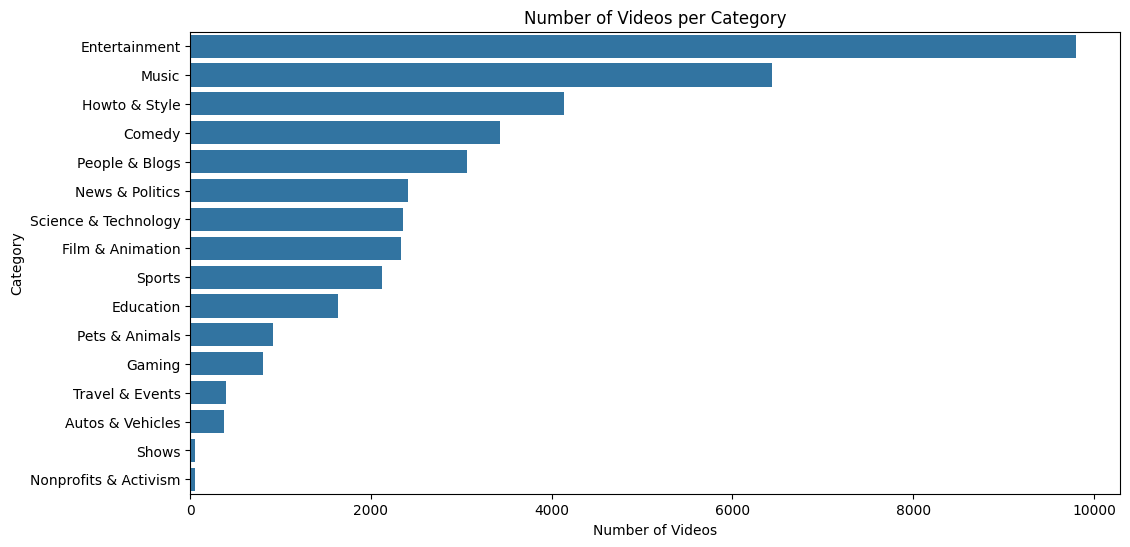

In [68]:
import seaborn as sns

# Plot the count of videos per category
plt.figure(figsize=(12, 6))
sns.countplot(data=df_selected, y='category', order=df_selected['category'].value_counts().index)
plt.title('Number of Videos per Category')
plt.xlabel('Number of Videos')
plt.ylabel('Category')
plt.show()

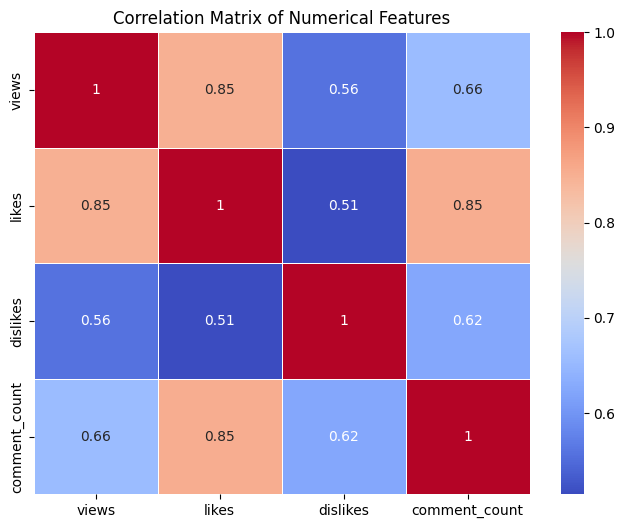

In [69]:
# Compute the correlation matrix
corr_matrix = df_selected[numerical_features].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

The correlation matrix reveals a strong positive relationship between **'views' and 'likes'**, indicating that videos with higher view counts tend to receive more likes. Similarly, 'views' and 'comment_count' are positively correlated, suggesting that more viewed videos attract more comments.

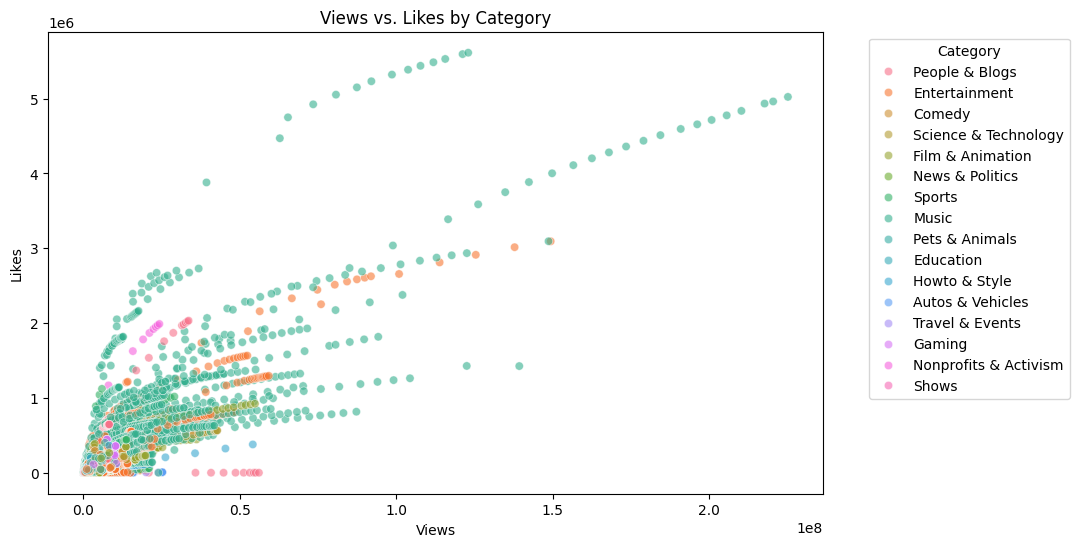

In [70]:
# Scatter plot of views vs. likes
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_selected, x='views', y='likes', hue='category', alpha=0.6)
plt.title('Views vs. Likes by Category')
plt.xlabel('Views')
plt.ylabel('Likes')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

This scatter plot shows a positive correlation between views and likes across different video categories, with higher view counts generally associated with more likes. The distribution also highlights that some categories, such as Music and Entertainment, have significantly higher engagement levels (likes and views) compared to others, demonstrating variability in audience interaction depending on the video type.

## **3. Model Building and Training**

* Feature engineering
    * Convert categorical variables (e.g., 'category_id') into numerical formats using one-hot encoding

In [77]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# One-hot encode the 'category' column
encoder = OneHotEncoder(sparse_output=False)  # Corrected parameter name
category_encoded = encoder.fit_transform(df_selected[['category']])

# Create a DataFrame for the encoded category columns
category_encoded_df = pd.DataFrame(category_encoded, columns=encoder.get_feature_names_out(['category']))

# Concatenate the encoded columns with the numerical features
numerical_features = ['views', 'likes', 'dislikes', 'comment_count']
df_for_clustering = pd.concat([df_selected[numerical_features].reset_index(drop=True),
                                category_encoded_df.reset_index(drop=True)], axis=1)

* Normalization
    * Scale numerical features to ensure they contribute equally to the clustering process

In [78]:
from sklearn.preprocessing import StandardScaler

# Normalize the numerical features
scaler = StandardScaler()
df_for_clustering[numerical_features] = scaler.fit_transform(df_for_clustering[numerical_features])


* Apply K-Means Clustering
    * Fit a K-Means clustering model to group videos based on their features

In [79]:
from sklearn.cluster import KMeans

# Apply K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)  # Start with 5 clusters as an example
kmeans.fit(df_for_clustering)

# Add cluster labels to the DataFrame
df_selected['cluster'] = kmeans.labels_


* Determine Optimal Number of Clusters
    * Use the Elbow Method to identify the optimal number of clusters

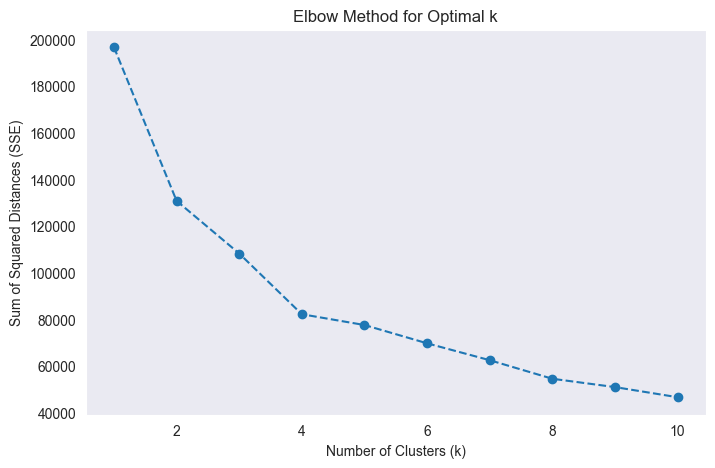

In [80]:
import matplotlib.pyplot as plt

# Determine the optimal number of clusters
sse = []  # Sum of squared distances for different cluster counts
k_range = range(1, 11)  # Test k from 1 to 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_for_clustering)
    sse.append(kmeans.inertia_)  # Inertia measures how tightly data is grouped

# Plot the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (SSE)')
plt.title('Elbow Method for Optimal k')
plt.grid()
plt.show()


This suggests that 4 clusters would be a good choice for grouping the YouTube videos, as the improvement in SSE beyond 4 clusters is minimal.

In [82]:
from sklearn.cluster import KMeans

# Apply K-Means clustering with k=4
kmeans = KMeans(n_clusters=4, random_state=42)  # Set n_clusters to 4
kmeans.fit(df_for_clustering)

# Add the cluster labels to the DataFrame
df_selected['cluster'] = kmeans.labels_

# Optionally, check the centroids of the clusters
centroids = kmeans.cluster_centers_
print("Cluster Centroids:", centroids)


Cluster Centroids: [[-1.01293738e-01 -1.06427444e-01 -6.02489139e-02 -8.48240566e-02
   9.60125652e-03  8.66393069e-02  4.15716674e-02  2.45376704e-01
   5.85195318e-02  1.96585094e-02  1.04701829e-01  1.47894817e-01
   6.09768455e-02  1.13999088e-03  7.65820540e-02  2.32051477e-02
   5.93808583e-02  1.44398845e-03  5.31489081e-02  1.01585854e-02]
 [ 3.99480371e+00  4.17886329e+00  1.85587813e+00  2.92360490e+00
   5.20417043e-18  1.35802469e-02 -6.93889390e-17  1.30864198e-01
   3.45679012e-02  3.20987654e-02  3.70370370e-03  6.90123457e-01
  -7.63278329e-17  2.46913580e-03  4.44444444e-02  1.73472348e-17
   1.72839506e-02  3.68628739e-18  3.08641975e-02 -1.21430643e-17]
 [ 1.42130600e+01  1.12616480e+01  5.91617650e+01  2.23781982e+01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   6.93889390e-18  0.00000000e+00  1.38777878e-17  2.77555756e-17
   0.00000000e+00  2.16840434e-19  0.00000000e+00  0.00000000e+00
   6.93889390e-18  2.16840434e-19  0.00000000e+00  0.00

In [83]:
# save the clustered dataset
df_selected.to_csv('clustered_videos.csv', index=False)

## **4. Results and Discussion:**

* **Cluster Analysis**

In [84]:
# Cluster labels were already added to df_selected as 'cluster'
print(df_selected[['title', 'cluster']].head())  # Example of the first few rows showing video titles and assigned clusters

                                               title  cluster
0                 WE WANT TO TALK ABOUT OUR MARRIAGE        0
1  The Trump Presidency: Last Week Tonight with J...        0
2  Racist Superman | Rudy Mancuso, King Bach & Le...        0
3                   Nickelback Lyrics: Real or Fake?        0
4                           I Dare You: GOING BALD!?        0


* Analyzing Cluster Characteristics

In [85]:
# Calculate the mean of numerical features for each cluster
cluster_means = df_selected.groupby('cluster')[['views', 'likes', 'dislikes', 'comment_count']].mean()
print(cluster_means)

                views         likes      dislikes  comment_count
cluster                                                         
0        1.618006e+06  5.017295e+04  2.111166e+03    5376.703932
1        3.206032e+07  1.034625e+06  4.654126e+04  108669.466667
2        1.080027e+08  2.661741e+06  1.375318e+06  776632.285714
3        1.225860e+08  4.206403e+06  2.641532e+05  697974.000000


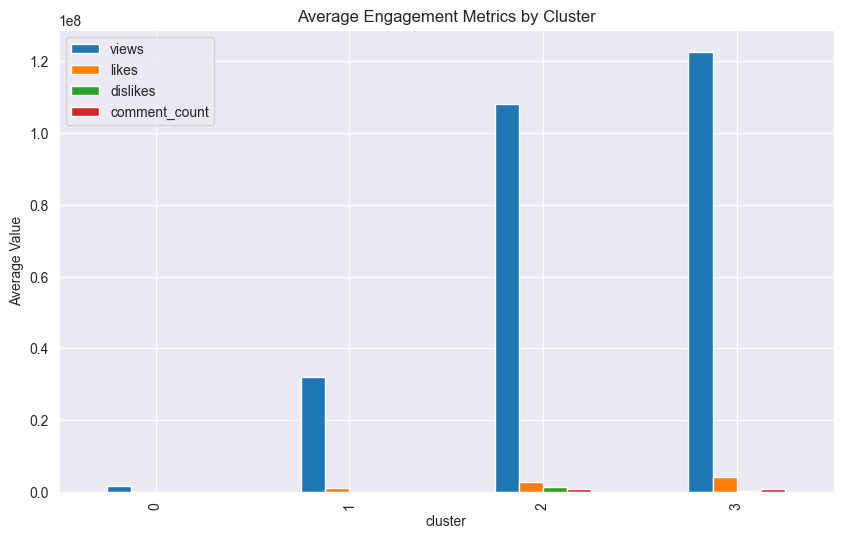

In [86]:
# Bar plot of the mean views, likes, etc., by cluster
cluster_means.plot(kind='bar', figsize=(10, 6))
plt.title('Average Engagement Metrics by Cluster')
plt.ylabel('Average Value')
plt.show()

The bar plot reveals distinct characteristics across the four clusters. Cluster 1 contains the most popular videos, with high views, likes, comments, and dislikes, suggesting they are widely engaging but polarizing. Cluster 0 represents low-engagement videos with minimal views and likes, likely targeting niche audiences or underperforming content. Clusters 2 and 3 exhibit moderate engagement, with Cluster 3 having slightly higher likes and comments than Cluster 2, indicating better audience interaction. These patterns highlight varying levels of video popularity and engagement.

##### **Summary of Insights:**

- **Cluster 1** contains the most popular videos with high engagement (views, likes, comments) but also higher levels of dislikes, which could indicate that while they are widely viewed, they are also polarizing.
- **Cluster 0** represents videos with lower engagement, possibly either niche or videos that didn't perform well despite being trending.
- **Cluster 2 and Cluster 3** represent videos with more moderate engagement, with Cluster 3 having higher interaction (likes, comments) than Cluster 2.

##### **What This Tells Us:**

- Videos in **Cluster 1** are likely the ones you would consider as the "viral" or highly popular content on YouTube, while **Cluster 0** may contain videos that are not engaging or are targeted at very niche audiences.
- **Cluster 2 and Cluster 3** may represent videos that are getting a steady amount of attention but haven't reached viral status.

* Identifying Patterns

In [90]:
# Check the most common category in each cluster
cluster_category = df_selected.groupby('cluster')['category'].agg(lambda x: x.mode()[0])
print(cluster_category)

cluster
0    Entertainment
1            Music
2    Entertainment
3            Music
Name: category, dtype: object


* Engagement Metrics

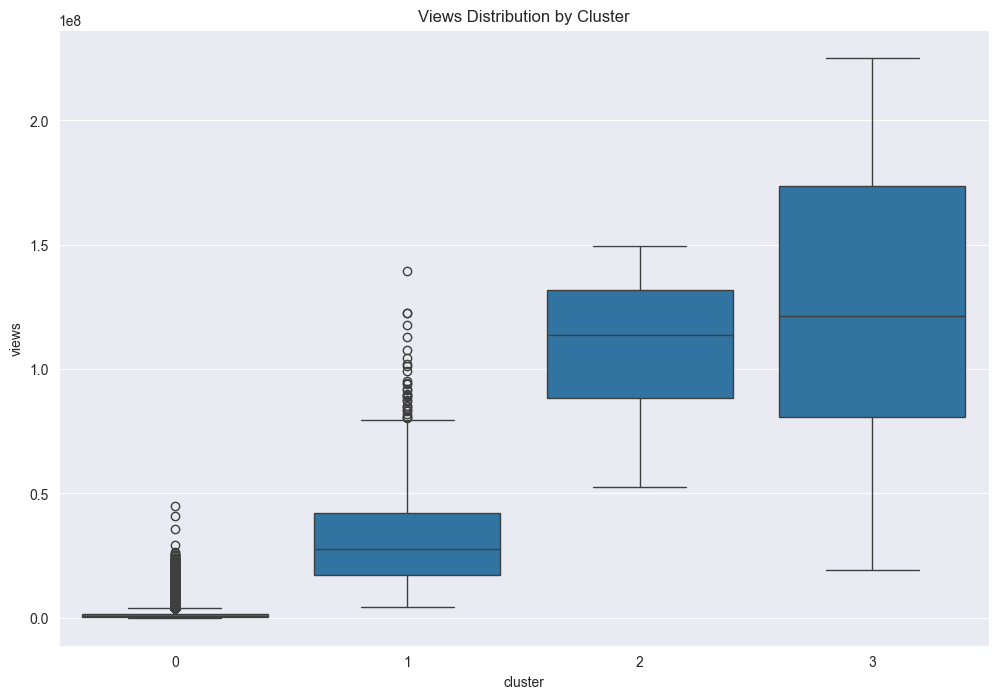

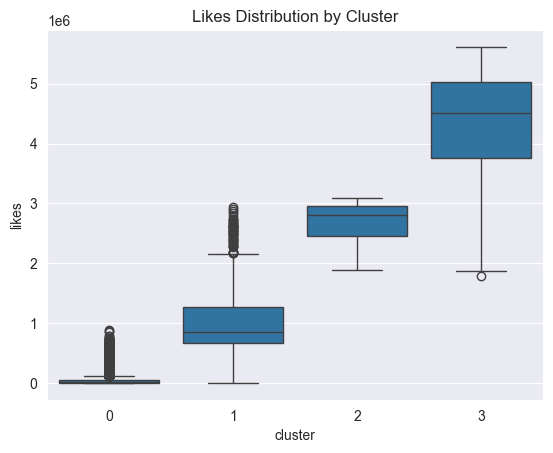

In [88]:
import seaborn as sns

# Plot distribution of views, likes, and comments for each cluster
plt.figure(figsize=(12, 8))
sns.boxplot(x='cluster', y='views', data=df_selected)
plt.title('Views Distribution by Cluster')
plt.show()

sns.boxplot(x='cluster', y='likes', data=df_selected)
plt.title('Likes Distribution by Cluster')
plt.show()

#### **Limitations:**

1. **Absence of Certain Features:**
   - **Watch Time:** A key limitation in your analysis is the absence of certain features, such as watch time or audience retention, which are crucial in understanding deeper engagement. Watch time can help differentiate videos that viewers are more likely to watch all the way through versus those with high views but short engagement.
   - **Video Length:** If available, video length could provide additional context. Shorter videos may receive higher engagement in certain clusters, while longer videos may perform better in others.
2. **Potential Biases in the Data:**
   - **Trending Data:** The dataset only represents videos that are trending at a specific point in time. This introduces a temporal bias, as the features of trending videos may not be representative of overall video performance. Additionally, trends can fluctuate, meaning videos that trend today may not have the same engagement the next day or week.
   - **Geographical Bias:** If the dataset includes data from different regions, there might be regional preferences that influence engagement metrics. The preferences in one region (e.g., US vs. France) may lead to differing cluster characteristics.
3. **Temporal Nature of Data:**
   - Since the dataset is based on trending videos, the analysis is inherently focused on a snapshot of time. Trending videos are, by nature, time-sensitive and may not have the same performance after a certain period. Long-term engagement or sustained popularity cannot be fully captured by this dataset.

### **Next Steps for Further Analysis:**

- Explore more sophisticated clustering methods (e.g., DBSCAN or hierarchical clustering) to see if they provide better grouping.
- Include additional features like video description text, tags, or sentiment analysis to improve the clustering.
- Investigate the effect of video length or publish time on the clusters.

## **5. Conclusion:**

In this project, I clustered trending YouTube videos based on both metadata (e.g., categories) and engagement metrics (e.g., views, likes, dislikes, and comment counts). Through this process, we identified patterns that contribute to the popularity of videos on the platform.

1. **Key Findings:**
   - **Cluster 1** represents high-performing, viral videos that garner significant views, likes, and comments, reflecting widespread appeal and strong audience engagement.
   - **Cluster 0** consists of low-engagement videos, likely with niche audiences or those struggling to capture significant attention, showing that not all trending videos are successful in terms of viewer interaction.
   - **Clusters 2 and 3** represent intermediate levels of engagement, with videos that have steady but moderate performance in views and likes, indicating a stable but less impactful reach compared to Cluster 1.
2. **Patterns Identified:**
   - **Popularity is strongly correlated with both views and likes**. Videos that achieve high views tend to receive higher engagement in terms of likes and comments, though some may still attract dislikes (suggesting mixed reactions to certain types of content).
   - **Certain categories** (such as Music or Entertainment) are more likely to appear in clusters with higher engagement, while other categories might not perform as well or may show more variability in engagement.
3. **Implications for Content Creators:**
   - To create content that trends successfully on YouTube, focusing on categories with higher engagement (like Music or Entertainment) can be a strategic advantage. Additionally, ensuring videos are highly engaging, sparking likes and comments, is crucial to reaching viral status.
   - Content that resonates with a niche audience (like Cluster 0) can still be valuable but may require different strategies for boosting visibility and engagement.
4. **Limitations and Future Considerations:**
   - This analysis is limited by the dataset, which only includes trending videos and doesn't account for long-term engagement or performance after the trending period. A more robust analysis would include watch time, audience retention, and sentiment analysis to further refine insights.
   - Additionally, factors such as the video’s description, title length, and timing of posting could also impact the engagement metrics but were not included in this analysis.